In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

# univariate multi-step lstm
from math import sqrt
from numpy import split
from numpy import array

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

import os
from google.colab import drive

Using TensorFlow backend.


In [0]:
!pip install -U tensorflow


In [0]:
drive.mount('/gdrive')
!ls


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
sample_data


In [0]:
path = '/gdrive/My Drive/UFRN/Mestrado/Machine Learning'
os.chdir(path)
with open('household_power_consumption.csv','r') as f:
  dataset = pd.read_csv(f, sep=';', 
                      header=0, low_memory=False, infer_datetime_format=True, 
                      parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [0]:
# dataset = pd.read_csv('household_power_consumption.csv', sep=';', 
#                       header=0, low_memory=False, infer_datetime_format=True, 
#                       parse_dates={'datetime':[0,1]}, index_col=['datetime'])



# dataset.drop('Voltage', inplace=True, axis=1)
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [0]:
colunas = ['Global_active_power', 'Global_reactive_power', 'Voltage',
           'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

for c in colunas:
    dataset[ dataset[c] == '?' ] = np.nan
    dataset[c] = dataset[c].astype('float32')
    

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [0]:
def fill_missing(values):
	one_day = 60 * 24
	for row in range(values.shape[0]):
		for col in range(values.shape[1]):
			if np.isnan(values[row, col]):
				values[row, col] = values[row - one_day, col]

fill_missing(dataset.values)

dataset['sub_metering_4'] = (dataset.iloc[:,0] * 1000 / 60) - (dataset.iloc[:,3] + dataset.iloc[:,4] + dataset.iloc[:,5])


# dataset['sub_metering_4'] = (dataset['Global_active_power']* 1000 / 60) - 
# 			(dataset['Sub_metering_1'] + dataset['Sub_metering_2'] + dataset['Sub_metering_3'])


In [0]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0,50.866669
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0,65.333336
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0,64.566666
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0,65.800003
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0,44.299999


In [0]:
daily_data = dataset.resample('D').sum()

daily_data.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0,14426.133789
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0,35889.066406
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0,23799.232422
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0,12234.900391
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0,25134.800781


In [0]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [0]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts_mae(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mae = mean_absolute_error(actual[:, i], predicted[:, i])
		# calculate rmse
		# rmse = sqrt(mse)
		# store
		scores.append(mae)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])
	score = (s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [0]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	
	# restructure into windows of weekly data
	train = np.array(np.split(train, len(train)/7))
	test = np.array(np.split(test, len(test)/7))
	
	return train, test

In [0]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [0]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [0]:
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 70, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [0]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat
 
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, predictions






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








lstm: [402.370] 411.4, 404.2, 363.8, 399.6, 404.2, 312.4, 497.7


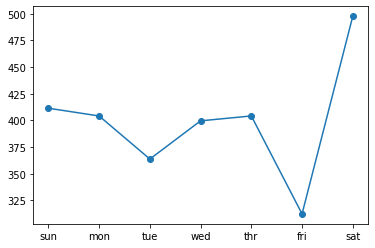

In [0]:
n_input = 7

train, test = split_dataset(daily_data.values)

score, scores, predictions = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
plt.plot(days, scores, marker='o', label='lstm')
plt.show()

[[2.0834541e+03 1.9161000e+02 3.5099212e+05 8.7035996e+03 3.8420000e+03
  4.9200000e+03 1.0074000e+04 1.7258633e+04]
 [1.6041320e+03 1.5640401e+02 3.5380672e+05 6.6232002e+03 0.0000000e+00
  2.9200000e+02 1.0812000e+04 1.9820334e+04]
 [2.2197800e+03 1.4893600e+02 3.5211028e+05 9.1397998e+03 1.7850000e+03
  2.9300000e+02 1.6468000e+04 2.5778533e+04]
 [1.7771801e+03 1.5208000e+02 3.5313812e+05 7.3613999e+03 1.7310000e+03
  3.2560000e+03 1.1359000e+04 1.7271268e+04]
 [1.7694420e+03 1.1502400e+02 3.5266834e+05 7.3003999e+03 1.1980000e+03
  2.5500000e+02 1.2936000e+04 2.0737301e+04]
 [1.7972080e+03 1.5978000e+02 3.5194294e+05 7.4180000e+03 0.0000000e+00
  9.9400000e+02 1.2531000e+04 2.1541467e+04]
 [2.3368999e+03 1.9939999e+02 3.5117241e+05 9.6962002e+03 2.7810000e+03
  4.8550000e+03 1.4734000e+04 2.1616133e+04]]
[1815.6837 1798.5371 1609.2733 1751.6981 1819.3964 1515.8828 1518.8063]
46
46


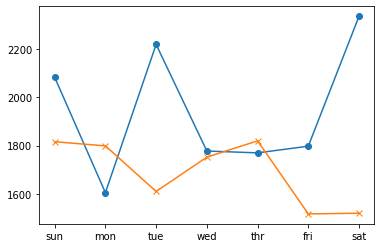

In [0]:
print(test[0])
print(predictions[0])

valores_reais_potencia_ativa = [2.0834541e+03,1.6041320e+03, 2.2197800e+03,1.7771801e+03,1.7694420e+03,1.7972080e+03,2.3368999e+03]

print(len(test))
print(len(predictions))

days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
plt.plot(days, valores_reais_potencia_ativa, marker='o', label='Real')
plt.plot(days, predictions[0], marker='x', label='Predito')
plt.show()

In [0]:
test[0,:,0] -predictions[0]

array([ 267.7704  , -194.40515 ,  610.5067  ,   25.481934,  -49.954346,
        281.3252  ,  818.0936  ], dtype=float32)

In [0]:
!pip install tsaug

In [0]:
!pip install transforms3d

     |████████████████████████████████| 71kB 2.6MB/s 
ERROR: Operation cancelled by user


In [0]:
from tsaug import RandomTimeWarp, RandomMagnify, RandomJitter, RandomTrend
my_aug = (
    RandomMagnify(max_zoom=4.0, min_zoom=2.0) * 2
    + RandomTimeWarp() * 2
    + RandomJitter(strength=0.1) @ 0.5
    + RandomTrend(min_anchor=-0.5, max_anchor=0.5) @ 0.5
)


X_aug = my_aug.run(train)


lstm: [428.863] 421.9, 535.0, 409.2, 399.5, 402.8, 333.8, 471.8


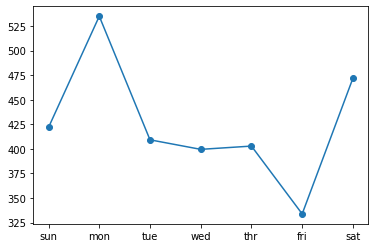

In [0]:
n_input = 7

# train, test = split_dataset(daily_data.values)

score_aug, scores_aug, predictions_aug = evaluate_model(X_aug, test, n_input)
# summarize scores
summarize_scores('lstm', score_aug, scores_aug)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
plt.plot(days, scores_aug, marker='o', label='lstm')
plt.show()

[1991.5447 1951.2191 1925.4637 1868.0996 1866.7415 1860.3645 1835.3258]


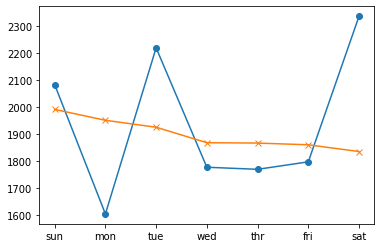

In [0]:
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
valores_reais_poten2
plt.plot(days, valores_reais_potencia_ativa, marker='o', label='lstm')
plt.plot(days, predictions_aug[0], marker='x', label='lstm')
plt.show()